## Stock Price Prediction with Sentiment Analysis

In [1]:
# # %%time
# !pip install pandas
# !pip install numpy
# !pip install yfinance
# !pip install torch
# !pip install transformers
# !pip install tqdm
# !pip install scikit-learn
# !pip install tensorflow
# !pip install statsmodels
# !pip install matplotlib
# !pip install keras-tuner
# !pip install pandas-datareader
# !pip install pandas_ta
# !pip install charset-normalizer

In [2]:
%%time
# To reload the imported modules automatically
%load_ext autoreload
%autoreload 2

CPU times: user 4.47 ms, sys: 4.7 ms, total: 9.17 ms
Wall time: 9.11 ms


In [3]:
%%time
# Import the necessary libraries and modules
import os
import warnings
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from statsmodels.tsa.stattools import adfuller

# Import modules
import config as cfg
import data_processing as dp
import sentiment_analysis as sa
import model as mdl
import utils as ut
import time
import keras_tuner as kt
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas_datareader.data as web

/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


CPU times: user 5.77 s, sys: 1.53 s, total: 7.3 s
Wall time: 11.7 s


In [4]:
%%time
start_time = time.time()
warnings.filterwarnings("ignore")
np.random.seed(42)
tf.random.set_seed(42)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.makedirs(cfg.DATASET_DIR, exist_ok=True)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/sandy/PycharmProjects/stock_market_analysis
CPU times: user 232 µs, sys: 347 µs, total: 579 µs
Wall time: 909 µs


In [5]:
%%time
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        # Set memory growth to be the same for all GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.list_logical_devices("GPU")
        print(
            f"✅ {len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs configured with memory growth."
        )

    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(f"Error setting memory growth: {e}")
else:
    print("🤷 No GPU detected. TensorFlow will run on CPU.")

✅ 1 Physical GPUs, 1 Logical GPUs configured with memory growth.
CPU times: user 1.59 ms, sys: 3.5 ms, total: 5.09 ms
Wall time: 11.4 ms


I0000 00:00:1754257029.979499  215150 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1754257029.979875  215150 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Load and Analyze News Data

In [6]:
%%time
sentiment_csv_path = f"{cfg.DATASET_DIR}/{cfg.STOCK_SYMBOL}_daily_sentiment.csv"

if cfg.UPDATE_SENTIMENT_CSV or not os.path.exists(sentiment_csv_path):
    print("Generating new sentiment data and saving to CSV...")
    news_df = dp.load_and_analyze_news_data(cfg.NEWS_DATA_FILE, cfg.STOCK_SYMBOL)
    company_sentiment_df = sa.process_news_sentiment(news_df, cfg.STOCK_SYMBOL)
    daily_sentiment_df = sa.aggregate_daily_sentiment(company_sentiment_df)
    ut.save_dataframe(daily_sentiment_df, sentiment_csv_path)
else:
    print(f"Loading existing sentiment data from {sentiment_csv_path}...")
    daily_sentiment_df = pd.read_csv(
        sentiment_csv_path, index_col="Date", parse_dates=True
    )

print("Sentiment data ready.")

Loading existing sentiment data from Dataset/NVDA_daily_sentiment.csv...
Sentiment data ready.
CPU times: user 4.08 ms, sys: 2.41 ms, total: 6.48 ms
Wall time: 11.1 ms


### Fetch Stock Data and Calculate Technical Indicators

In [7]:
%%time
START_DATE, END_DATE = ut.calculate_dynamic_date_range(daily_sentiment_df)

stock_filename = f"{cfg.STOCK_SYMBOL}_stock_data_{START_DATE}_to_{END_DATE}.csv"
stock_csv_path = os.path.join(cfg.DATASET_DIR, stock_filename)

if cfg.UPDATE_STOCK_CSV or not os.path.exists(stock_csv_path):
    print(f"Fetching new stock data from yfinance ({START_DATE} to {END_DATE})...")
    stock_data = dp.fetch_stock_data(cfg.STOCK_SYMBOL, START_DATE, END_DATE)
    if stock_data is not None:
        stock_data.to_csv(stock_csv_path)
        print(f"Stock data saved to {stock_csv_path}")
else:
    print(f"Loading existing stock data from {stock_csv_path}...")
    stock_data = pd.read_csv(stock_csv_path, index_col="Date", parse_dates=True)
    stock_data.index = stock_data.index.tz_localize("UTC")

if stock_data.index.tz is None:
    # If index is naive (from CSV), localize it to UTC
    print("Localizing naive index to UTC...")
    stock_data.index = stock_data.index.tz_localize("UTC")
else:
    # If index is already aware (from yfinance), convert it to UTC
    print("Converting timezone-aware index to UTC...")
    stock_data.index = stock_data.index.tz_convert("UTC")

Fetching new stock data from yfinance (2010-03-03 to 2020-06-10)...
\n📈 Fetching stock data for NVDA...
Successfully fetched 2586 days of data.
Stock data saved to Dataset/NVDA_stock_data_2010-03-03_to_2020-06-10.csv
Converting timezone-aware index to UTC...
CPU times: user 49.6 ms, sys: 31.1 ms, total: 80.7 ms
Wall time: 512 ms


#### Add Return Column (Percentage Change)

In [8]:
%%time
# Calculate daily returns, which will be our new target variable
print("--- Calculating Daily Returns ---")
stock_data["Returns"] = stock_data["Close"].pct_change()
tech_data = stock_data.dropna()  # Drop the first row which will have a NaN return
print("'Returns' column created.")

--- Calculating Daily Returns ---
'Returns' column created.
CPU times: user 1.23 ms, sys: 327 µs, total: 1.56 ms
Wall time: 1.89 ms


### Prepare data for the Baseline model

In [9]:
%%time
# Prepare data for the Baseline model
X_train_base, X_test_base, y_train_base, y_test_base, scaler_base = (
    mdl.prepare_data_for_lstm(
        tech_data,
        cfg.BASELINE_FEATURES,
        cfg.BASELINE_TARGET,
        cfg.SEQUENCE_LENGTH,
        cfg.TEST_SIZE,
    )
)

print(
    f"Baseline data shapes: X_train={X_train_base.shape}, y_train={y_train_base.shape}, X_test={X_test_base.shape}, y_test={y_test_base.shape}"
)

Baseline data shapes: X_train=(2296, 30, 2), y_train=(2296,), X_test=(259, 30, 2), y_test=(259,)
CPU times: user 2.43 ms, sys: 342 µs, total: 2.77 ms
Wall time: 2.92 ms


#### Macroeconomic Data from FRED

In [10]:
%%time
if stock_data is not None:
    print("\n--- Fetching and Merging Macroeconomic Data ---")

    # Define the FRED series codes and their new column names
    fred_series = {
        "CPIAUCSL": "Inflation_CPI",
        "FEDFUNDS": "Interest_Rate",
        "UNRATE": "Unemployment_Rate",
    }

    # Fetch the data from FRED
    macro_data = web.DataReader(list(fred_series.keys()), "fred", START_DATE, END_DATE)
    macro_data = macro_data.rename(columns=fred_series)

    stock_data.index = stock_data.index.tz_localize(None)

    # Forward-fill the macroeconomic data, as it's released monthly and is assumed
    # to be constant until the next release period.
    macro_data_daily = macro_data.reindex(stock_data.index, method="ffill")

    # Merge the data
    stock_data = stock_data.join(macro_data_daily)

    # Fill any NaNs at the beginning
    stock_data.bfill(inplace=True)
    print("Macroeconomic features merged successfully.")


--- Fetching and Merging Macroeconomic Data ---
Macroeconomic features merged successfully.
CPU times: user 22.7 ms, sys: 5.07 ms, total: 27.7 ms
Wall time: 1.33 s


In [11]:
# Calculate technical indicators from the loaded/fetched data
tech_data = dp.calculate_technical_indicators(stock_data)
print("Technical indicators calculated.")

Technical indicators calculated.


#### VIX (Volatility Index) Data

In [12]:
## Add VIX (Volatility Index) Data
print("--- Applying Final Fix: Normalizing Dates ---")
try:
    # 1. Standardize tech_data index to UTC
    if tech_data.index.tz is None:
        tech_data.index = tech_data.index.tz_localize("UTC")
    else:
        tech_data.index = tech_data.index.tz_convert("UTC")

    # 2. Standardize VIX data index to UTC
    vix_data = yf.Ticker("^VIX").history(start=START_DATE, end=END_DATE)
    vix_data.index = vix_data.index.tz_convert("UTC")

    # --- NEW FIX: NORMALIZE BOTH INDEXES TO MIDNIGHT ---
    print("\nNormalizing indexes to match on date alone...")
    tech_data.index = tech_data.index.normalize()
    vix_data.index = vix_data.index.normalize()
    print(f"-> Normalized tech_data index starts: {tech_data.index[0]}")
    print(f"-> Normalized VIX index starts:    {vix_data.index[0]}")

    # 3. Perform the join on the normalized indexes
    print("\nJoining dataframes...")
    vix_close = vix_data[["Close"]].rename(columns={"Close": "VIX_Close"})
    tech_data = tech_data.join(vix_close)

    # 4. Check the result
    nan_count = tech_data["VIX_Close"].isna().sum()
    total_count = len(tech_data)
    print(
        f"\nAfter join, VIX_Close has {nan_count} NaN values out of {total_count} rows."
    )

    if nan_count == total_count:
        print("-> WARNING: Join still resulted in all NaN values.")
    else:
        print("-> SUCCESS: Join completed with matching dates.")

    # Fill any remaining NaNs (from non-trading days)
    tech_data.ffill(inplace=True)
    tech_data.bfill(inplace=True)

    print("\n--- VIX Feature Added Successfully ---")

except Exception as e:
    print(f"\n--- AN ERROR OCCURRED ---")
    import traceback

    traceback.print_exc()

--- Applying Final Fix: Normalizing Dates ---

Normalizing indexes to match on date alone...
-> Normalized tech_data index starts: 2010-12-14 00:00:00+00:00
-> Normalized VIX index starts:    2010-03-03 00:00:00+00:00

Joining dataframes...

After join, VIX_Close has 0 NaN values out of 2387 rows.
-> SUCCESS: Join completed with matching dates.

--- VIX Feature Added Successfully ---


In [13]:
%%time
print("--- Checking for Stationarity of the 'Returns' ---")

adf_result = adfuller(tech_data["Returns"])

print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

if adf_result[1] > 0.05:
    print(
        "Result: The 'Returns' price series is likely non-stationary (p-value > 0.05)"
    )
else:
    print("Result: The 'Returns' price series is likely stationary (p-value <= 0.05)")

--- Checking for Stationarity of the 'Returns' ---
ADF Statistic: -15.457348885740526
p-value: 2.734261093949173e-28
Result: The 'Returns' price series is likely stationary (p-value <= 0.05)
CPU times: user 36.1 ms, sys: 13.7 ms, total: 49.8 ms
Wall time: 46.9 ms


In [14]:
ut.save_dataframe(
    tech_data, f"{cfg.OUTPUT_DIR}/" + cfg.STOCK_SYMBOL + "_technical_indicators.csv"
)

DataFrame saved to Output/NVDA_technical_indicators.csv


### Prepare Data for LSTM & SVM Models

In [15]:
%%time
# Prepare data for models using only technical indicators
X_train_tech, X_test_tech, y_train_tech, y_test_tech, scaler_tech = (
    mdl.prepare_data_for_lstm(
        tech_data,
        cfg.TECHNICAL_FEATURES,
        cfg.TECHNICAL_TARGET,
        cfg.SEQUENCE_LENGTH,
        cfg.TEST_SIZE,
    )
)

# Prepare data for models using sentiment + technical indicators
enhanced_full_data = dp.create_enhanced_dataset(tech_data, daily_sentiment_df)
X_train_enh, X_test_enh, y_train_enh, y_test_enh, scaler_enh = (
    mdl.prepare_data_for_lstm(
        enhanced_full_data,
        cfg.HYBRID_FEATURES,
        cfg.HYBRID_TARGET,
        cfg.SEQUENCE_LENGTH,
        cfg.TEST_SIZE,
    )
)


🔗 Merging sentiment and technical data...
Enhanced dataset shape: (2387, 42)
CPU times: user 8.14 ms, sys: 2.06 ms, total: 10.2 ms
Wall time: 9.62 ms


### Single Layer Baseline LSTM Model

In [16]:
%%time
print("\n--- Tuning Baseline Single-Layer LSTM Model ---")

# Define the input shape from your baseline training data
input_shape_base = (X_train_base.shape[1], X_train_base.shape[2])

# Instantiate the tuner for the baseline model
tuner_baseline_lstm = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_single_layer_lstm(hp, input_shape=input_shape_base),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="baseline_single_layer_lstm",  # Use a new project name
    overwrite=False,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the baseline data
print("Starting hyperparameter search for the baseline model...")
tuner_baseline_lstm.search(
    X_train_base,
    y_train_base,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\nBaseline hyperparameter search complete.")

# Get the optimal hyperparameters and the best model for the baseline
best_hps_baseline_lstm = tuner_baseline_lstm.get_best_hyperparameters(num_trials=1)[0]
baseline_lstm_model = tuner_baseline_lstm.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Baseline Single-Layer LSTM:
Units: {best_hps_baseline_lstm.get('units')}
Dropout: {best_hps_baseline_lstm.get('dropout'):.2f}
Learning Rate: {best_hps_baseline_lstm.get('learning_rate')}
---
"""
)


--- Tuning Baseline Single-Layer LSTM Model ---
Reloading Tuner from tuner_results/baseline_single_layer_lstm/tuner0.json
Starting hyperparameter search for the baseline model...

Baseline hyperparameter search complete.

---
Optimal Hyperparameters for Baseline Single-Layer LSTM:
Units: 224
Dropout: 0.20
Learning Rate: 0.01
---

CPU times: user 450 ms, sys: 134 ms, total: 584 ms
Wall time: 671 ms



--- Evaluating Tuned Baseline LSTM Model ---
{'Model': 'Baseline LSTM', 'RMSE': np.float64(0.03468835274507145), 'MAE': 0.02396809831429071, 'MAPE (%)': np.float64(9837.82016839269), 'R-squared': -0.0017130638663318543, 'Directional_Accuracy': np.float64(62.4031007751938), 'MASE': np.float64(0.45395110499812735)}
Plot saved to Output/NVDA_Baseline_LSTM_analysis.png


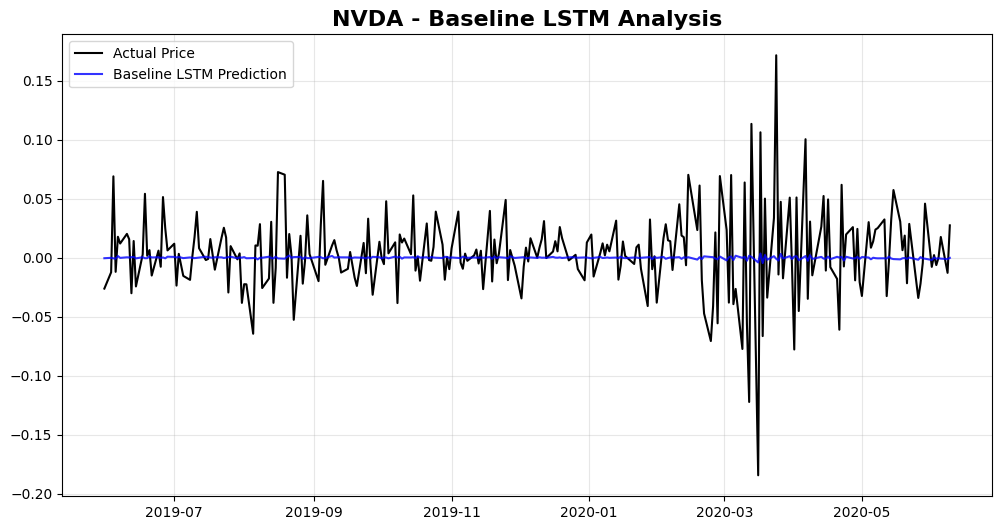

In [17]:
# --- Evaluation ---
print("\n--- Evaluating Tuned Baseline LSTM Model ---")

# Generate predictions on the baseline test set
baseline_preds = baseline_lstm_model.predict(X_test_base, verbose=0)

# --- Correct way to inverse scale the predictions ---
# 1. Create a new scaler for the single target column ('Returns')
target_scaler = MinMaxScaler()

# 2. Fit it ONLY on the 'Returns' column of the TRAINING data
#    We use 'tech_data' as it's the source DataFrame before splitting.
train_data_len = len(tech_data) - len(y_test_base)
target_scaler.fit(tech_data[["Returns"]][:train_data_len])

# 3. Now, inverse transform using the correctly fitted scaler
y_test_base_scaled = target_scaler.inverse_transform(y_test_base.reshape(-1, 1))
baseline_preds_scaled = target_scaler.inverse_transform(baseline_preds)


# Calculate and print the performance metrics
baseline_lstm_metrics = ut.calculate_metrics(
    y_test_base_scaled, baseline_preds_scaled, "Baseline LSTM", y_train_base
)
print(baseline_lstm_metrics)


# Plot the prediction results against the actual values
test_dates_base = tech_data.index[-len(y_test_base_scaled) :]
ut.plot_non_keras_results(
    y_test_base_scaled,
    baseline_preds_scaled,
    test_dates_base,
    cfg.STOCK_SYMBOL,
    "Baseline LSTM",
)

### Single Layer Technical LSTM Model

In [18]:
%%time
print("\n--- Tuning Single-Layer Technical LSTM Model ---")

# Define the input shape from your technical training data
input_shape_tech = (X_train_tech.shape[1], X_train_tech.shape[2])

# Instantiate the tuner for the technical model
tuner_single_lstm_tech = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_single_layer_lstm(hp, input_shape=input_shape_tech),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="technical_single_layer_lstm",  # More descriptive project name
    overwrite=False,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the technical data
print("Starting hyperparameter search for the technical model...")
tuner_single_lstm_tech.search(
    X_train_tech,
    y_train_tech,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\nTechnical model hyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_single_lstm_tech = tuner_single_lstm_tech.get_best_hyperparameters(
    num_trials=1
)[0]
single_lstm_model_tech = tuner_single_lstm_tech.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Single-Layer Technical LSTM:
Units: {best_hps_single_lstm_tech.get('units')}
Dropout: {best_hps_single_lstm_tech.get('dropout'):.2f}
Learning Rate: {best_hps_single_lstm_tech.get('learning_rate')}
---
"""
)


--- Tuning Single-Layer Technical LSTM Model ---
Reloading Tuner from tuner_results/technical_single_layer_lstm/tuner0.json
Starting hyperparameter search for the technical model...

Technical model hyperparameter search complete.

---
Optimal Hyperparameters for Single-Layer Technical LSTM:
Units: 192
Dropout: 0.40
Learning Rate: 0.01
---

CPU times: user 410 ms, sys: 52 ms, total: 462 ms
Wall time: 483 ms



--- Evaluating Best Single-Layer Technical LSTM Model ---
{'Model': 'Single-Layer Technical LSTM', 'RMSE': np.float64(0.035488965646567325), 'MAE': 0.024420057433134492, 'MAPE (%)': np.float64(12375.477921329933), 'R-squared': -0.013352142137115885, 'Directional_Accuracy': np.float64(28.57142857142857), 'MASE': np.float64(0.47767521018133524)}
Plot saved to Output/NVDA_Single-Layer_Technical_LSTM_analysis.png


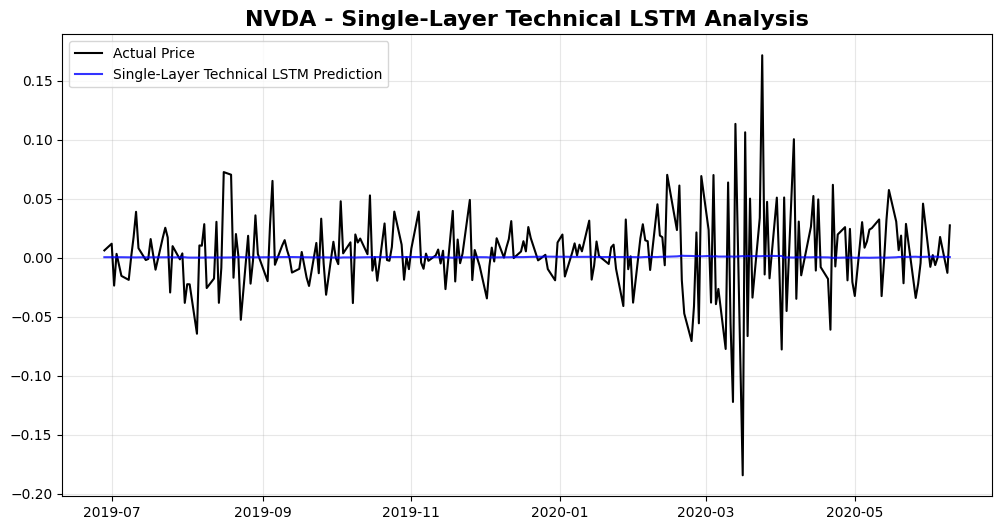

CPU times: user 315 ms, sys: 30.6 ms, total: 345 ms
Wall time: 360 ms


In [19]:
%%time
# --- Evaluation using the best technical model ---
print("\n--- Evaluating Best Single-Layer Technical LSTM Model ---")

# Generate predictions on the technical test set
single_layer_lstm_preds_tech = single_lstm_model_tech.predict(X_test_tech, verbose=0)

# --- Correct way to inverse scale the predictions ---
# 1. Create a new scaler for the single target column ('Returns')
target_scaler_tech = MinMaxScaler()

# 2. Fit it ONLY on the 'Returns' column of the TRAINING data
train_data_len_tech = len(tech_data) - len(y_test_tech)
target_scaler_tech.fit(tech_data[["Returns"]][:train_data_len_tech])

# 3. Now, inverse transform using the correctly fitted scaler
y_test_tech_scaled = target_scaler_tech.inverse_transform(y_test_tech.reshape(-1, 1))
tech_preds_scaled = target_scaler_tech.inverse_transform(single_layer_lstm_preds_tech)


# Calculate and print metrics for the technical model
tech_metrics = ut.calculate_metrics(
    y_test_tech_scaled, tech_preds_scaled, "Single-Layer Technical LSTM", y_train_tech
)
print(tech_metrics)

# Plot the results
test_dates_tech = tech_data.index[-len(y_test_tech_scaled) :]
ut.plot_non_keras_results(
    y_test_tech_scaled,
    tech_preds_scaled,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "Single-Layer Technical LSTM",
)

### Single-Layer Enhanced LSTM Model

In [20]:
%%time
print("\n--- Tuning Single-Layer Hybrid/Enhanced LSTM Model ---")

# Define the input shape from your hybrid/enhanced training data
input_shape_enh = (X_train_enh.shape[1], X_train_enh.shape[2])

# Instantiate the tuner for the hybrid/enhanced model
tuner_single_lstm_enh = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_single_layer_lstm(hp, input_shape=input_shape_enh),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="hybrid_enhanced_single_layer_lstm",  # Made name more specific
    overwrite=False,
)

# Define a callback for early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the hybrid/enhanced data
print("Starting hyperparameter search on hybrid/enhanced data...")
tuner_single_lstm_enh.search(
    X_train_enh,
    y_train_enh,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\nHybrid/Enhanced model hyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_single_lstm_enh = tuner_single_lstm_enh.get_best_hyperparameters(num_trials=1)[
    0
]
single_lstm_model_enh = tuner_single_lstm_enh.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Single-Layer Hybrid/Enhanced LSTM:
Units: {best_hps_single_lstm_enh.get('units')}
Dropout: {best_hps_single_lstm_enh.get('dropout'):.2f}
Learning Rate: {best_hps_single_lstm_enh.get('learning_rate')}
---
"""
)


--- Tuning Single-Layer Hybrid/Enhanced LSTM Model ---
Reloading Tuner from tuner_results/hybrid_enhanced_single_layer_lstm/tuner0.json
Starting hyperparameter search on hybrid/enhanced data...

Hybrid/Enhanced model hyperparameter search complete.

---
Optimal Hyperparameters for Single-Layer Hybrid/Enhanced LSTM:
Units: 96
Dropout: 0.30
Learning Rate: 0.01
---

CPU times: user 385 ms, sys: 32.1 ms, total: 418 ms
Wall time: 438 ms



--- Evaluating Best Single-Layer Hybrid/Enhanced LSTM Model ---
{'Model': 'Single-Layer Hybrid LSTM', 'RMSE': np.float64(0.04089627978460143), 'MAE': 0.028347596780252227, 'MAPE (%)': np.float64(18726.65620392041), 'R-squared': -0.3456784981965699, 'Directional_Accuracy': np.float64(70.58823529411765), 'MASE': np.float64(0.5545009174208418)}
Plot saved to Output/NVDA_Single-Layer_Hybrid_LSTM_analysis.png


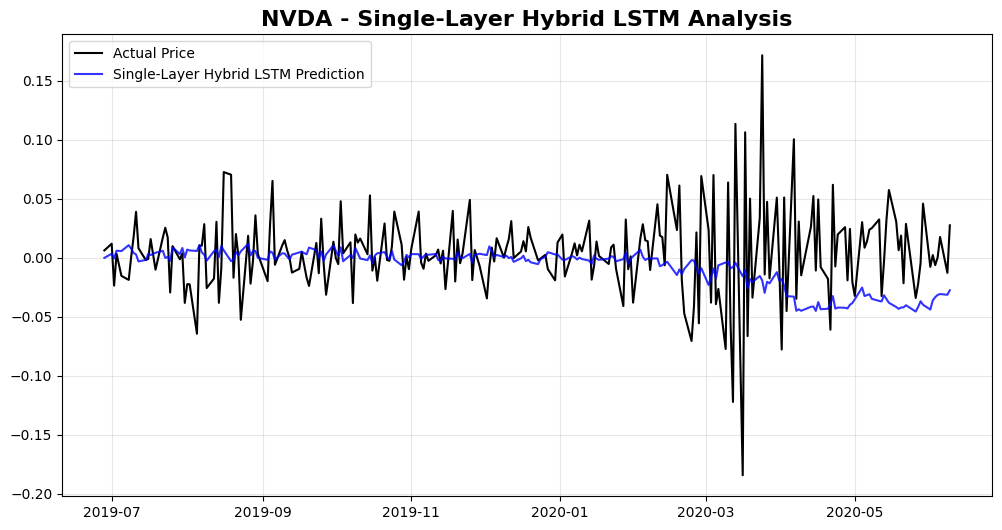

CPU times: user 303 ms, sys: 29.8 ms, total: 332 ms
Wall time: 420 ms


In [21]:
%%time
# --- Evaluation using the best hybrid/enhanced model ---
print("\n--- Evaluating Best Single-Layer Hybrid/Enhanced LSTM Model ---")

# Generate predictions on the hybrid/enhanced test set
single_layer_lstm_preds_enh = single_lstm_model_enh.predict(X_test_enh, verbose=0)

# --- Correct way to inverse scale the predictions ---
# 1. Create a new scaler for the single target column ('Returns')
target_scaler_enh = MinMaxScaler()

# 2. Fit it ONLY on the 'Returns' column of the TRAINING data
train_data_len_enh = len(enhanced_full_data) - len(y_test_enh)
target_scaler_enh.fit(enhanced_full_data[["Returns"]][:train_data_len_enh])

# 3. Now, inverse transform using the correctly fitted scaler
y_test_enh_scaled = target_scaler_enh.inverse_transform(y_test_enh.reshape(-1, 1))
enh_preds_scaled = target_scaler_enh.inverse_transform(single_layer_lstm_preds_enh)

# Calculate and print metrics for the hybrid/enhanced model
enh_metrics = ut.calculate_metrics(
    y_test_enh_scaled, enh_preds_scaled, "Single-Layer Hybrid LSTM", y_train_enh
)
print(enh_metrics)

# Plot the results
test_dates_enh = enhanced_full_data.index[-len(y_test_enh_scaled) :]
ut.plot_non_keras_results(
    y_test_enh_scaled,
    enh_preds_scaled,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Single-Layer Hybrid LSTM",
)

##### Compare Single Layer LSTM Model

Plot saved to Output/NVDA_all_models_comparison.png


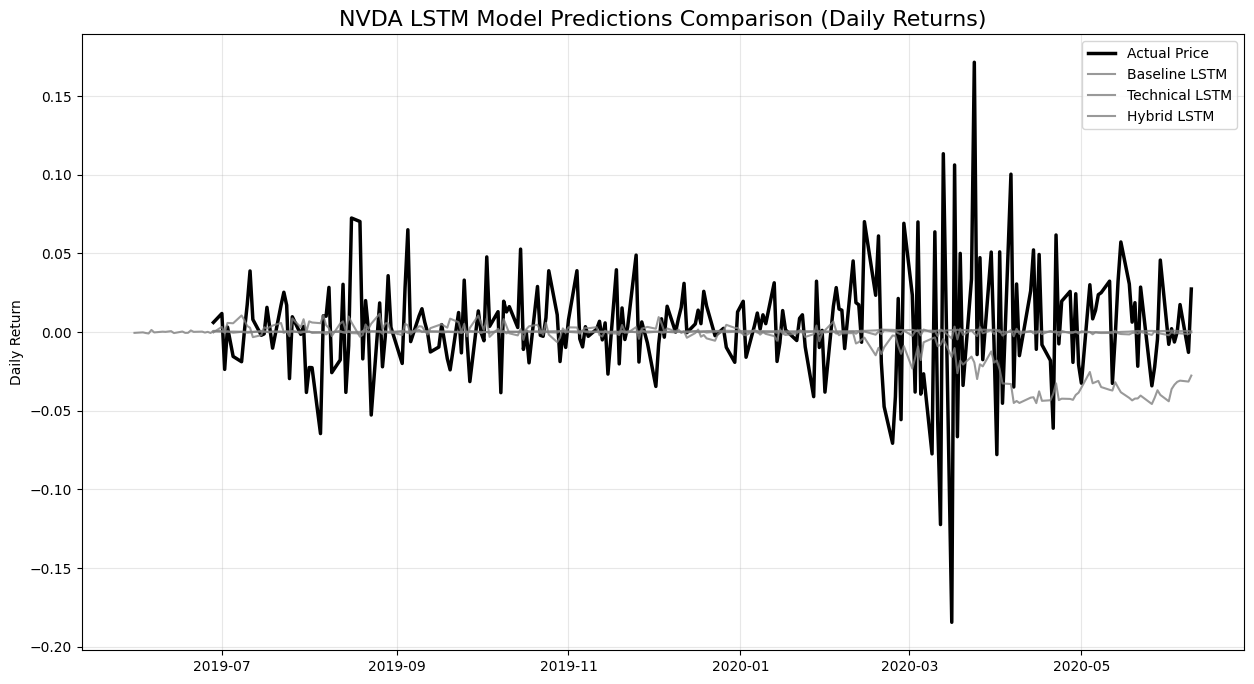

CPU times: user 159 ms, sys: 9.31 ms, total: 169 ms
Wall time: 180 ms


In [22]:
%%time

plot_data = {
    "Actual": {"dates": test_dates_enh, "values": y_test_enh_scaled},
    "Baseline LSTM": {"dates": test_dates_base, "values": baseline_preds_scaled},
    "Technical LSTM": {"dates": test_dates_tech, "values": tech_preds_scaled},
    "Hybrid LSTM": {"dates": test_dates_enh, "values": enh_preds_scaled},
}

ut.plot_final_comparison(
    plot_data,
    cfg.STOCK_SYMBOL,
    f"{cfg.STOCK_SYMBOL} LSTM Model Predictions Comparison (Daily Returns)",
)

### Multi-Layer Baseline LSTM Models

In [23]:
%%time
print("\n--- Tuning Baseline Multi-Layer LSTM Model ---")

# Define the input shape from your baseline training data
input_shape_base = (X_train_base.shape[1], X_train_base.shape[2])

# Instantiate the tuner for the baseline multi-layer model
tuner_multi_lstm_base = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_multi_layer_lstm(hp, input_shape=input_shape_base),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="baseline_multi_layer_lstm",  # New project name
    overwrite=False,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the baseline data
print("Starting hyperparameter search for the baseline multi-layer model...")
tuner_multi_lstm_base.search(
    X_train_base,
    y_train_base,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\nBaseline multi-layer hyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_multi_lstm_base = tuner_multi_lstm_base.get_best_hyperparameters(num_trials=1)[
    0
]
multi_layer_model_base = tuner_multi_lstm_base.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Baseline Multi-Layer LSTM:
Units Layer 1: {best_hps_multi_lstm_base.get('units_1')}
Units Layer 2: {best_hps_multi_lstm_base.get('units_2')}
Dropout: {best_hps_multi_lstm_base.get('dropout'):.2f}
Learning Rate: {best_hps_multi_lstm_base.get('learning_rate')}
---
"""
)


--- Tuning Baseline Multi-Layer LSTM Model ---
Reloading Tuner from tuner_results/baseline_multi_layer_lstm/tuner0.json
Starting hyperparameter search for the baseline multi-layer model...

Baseline multi-layer hyperparameter search complete.

---
Optimal Hyperparameters for Baseline Multi-Layer LSTM:
Units Layer 1: 64
Units Layer 2: 32
Dropout: 0.10
Learning Rate: 0.001
---

CPU times: user 504 ms, sys: 51.5 ms, total: 555 ms
Wall time: 593 ms



--- Evaluating Best Baseline Multi-Layer LSTM Model ---
{'Model': 'Multi-Layer Baseline LSTM', 'RMSE': np.float64(0.035025981583683814), 'MAE': 0.024210977650755448, 'MAPE (%)': np.float64(1613.2116996493135), 'R-squared': -0.021307718067440362, 'Directional_Accuracy': np.float64(31.3953488372093), 'MASE': np.float64(0.45855119223590546)}
Plot saved to Output/NVDA_Multi-Layer_Baseline_LSTM_analysis.png


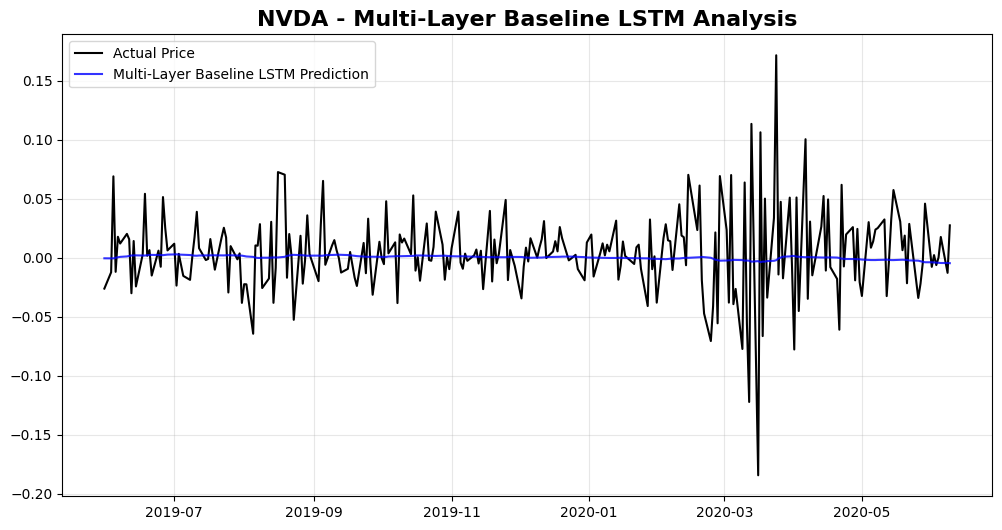

CPU times: user 458 ms, sys: 51.1 ms, total: 509 ms
Wall time: 765 ms


In [24]:
%%time
# --- Evaluation using the best baseline multi-layer model ---
print("\n--- Evaluating Best Baseline Multi-Layer LSTM Model ---")

# Generate predictions on the baseline test set
multi_layer_preds_base = multi_layer_model_base.predict(X_test_base, verbose=0)

# --- Correct way to inverse scale the predictions ---
# 1. Create a new scaler for the single target column ('Returns')
target_scaler_base_ml = MinMaxScaler()  # Use a unique name to avoid conflicts

# 2. Fit it ONLY on the 'Returns' column of the TRAINING data
train_data_len_base = len(tech_data) - len(y_test_base)
target_scaler_base_ml.fit(tech_data[["Returns"]][:train_data_len_base])

# 3. Now, inverse transform using the correctly fitted scaler
y_test_base_scaled = target_scaler_base_ml.inverse_transform(y_test_base.reshape(-1, 1))
multi_preds_scaled_base = target_scaler_base_ml.inverse_transform(
    multi_layer_preds_base
)


# Calculate and print metrics
multi_layer_metrics_base = ut.calculate_metrics(
    y_test_base_scaled,
    multi_preds_scaled_base,
    "Multi-Layer Baseline LSTM",
    y_train_base,
)
print(multi_layer_metrics_base)

# Plot the results
test_dates_base = tech_data.index[-len(y_test_base_scaled) :]
ut.plot_non_keras_results(
    y_test_base_scaled,
    multi_preds_scaled_base,
    test_dates_base,
    cfg.STOCK_SYMBOL,
    "Multi-Layer Baseline LSTM",
)

### Multi-Layer Technical LSTM Model

In [25]:
%%time
print("\n--- Tuning Multi-Layer Technical LSTM Model ---")

# Define the input shape from your technical training data
input_shape_tech = (X_train_tech.shape[1], X_train_tech.shape[2])

# Instantiate the tuner for the technical multi-layer model
tuner_multi_lstm_tech = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_multi_layer_lstm(hp, input_shape=input_shape_tech),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="technical_multi_layer_lstm",  # Specific project name
    overwrite=False,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the technical data
print("Starting hyperparameter search for the technical multi-layer model...")
tuner_multi_lstm_tech.search(
    X_train_tech,
    y_train_tech,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\nTechnical multi-layer hyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_multi_lstm_tech = tuner_multi_lstm_tech.get_best_hyperparameters(num_trials=1)[
    0
]
multi_layer_model_tech = tuner_multi_lstm_tech.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Multi-Layer Technical LSTM:
Units Layer 1: {best_hps_multi_lstm_tech.get('units_1')}
Units Layer 2: {best_hps_multi_lstm_tech.get('units_2')}
Dropout: {best_hps_multi_lstm_tech.get('dropout'):.2f}
Learning Rate: {best_hps_multi_lstm_tech.get('learning_rate')}
---
"""
)


--- Tuning Multi-Layer Technical LSTM Model ---
Reloading Tuner from tuner_results/technical_multi_layer_lstm/tuner0.json
Starting hyperparameter search for the technical multi-layer model...

Technical multi-layer hyperparameter search complete.

---
Optimal Hyperparameters for Multi-Layer Technical LSTM:
Units Layer 1: 128
Units Layer 2: 32
Dropout: 0.40
Learning Rate: 0.01
---

CPU times: user 490 ms, sys: 60.4 ms, total: 550 ms
Wall time: 597 ms



--- Evaluating Best Multi-Layer Technical LSTM Model ---
{'Model': 'Multi-Layer Technical LSTM', 'RMSE': np.float64(0.03544595435498406), 'MAE': 0.024372426692880953, 'MAPE (%)': np.float64(12369.772752614794), 'R-squared': -0.010897341236393299, 'Directional_Accuracy': np.float64(74.78991596638656), 'MASE': np.float64(0.4767435160637436)}
Plot saved to Output/NVDA_Multi-Layer_Technical_LSTM_analysis.png


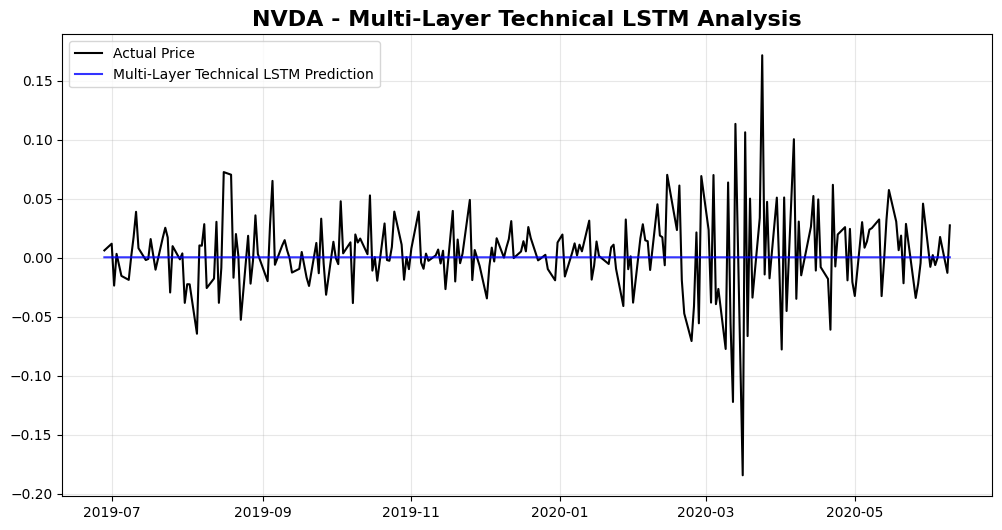

CPU times: user 470 ms, sys: 53.6 ms, total: 524 ms
Wall time: 800 ms


In [26]:
%%time
# --- Evaluation using the best technical multi-layer model ---
print("\n--- Evaluating Best Multi-Layer Technical LSTM Model ---")

# Generate predictions on the technical test set
multi_layer_preds_tech = multi_layer_model_tech.predict(X_test_tech, verbose=0)

# --- Correct way to inverse scale the predictions ---
# 1. Create a new scaler for the single target column ('Returns')
target_scaler_tech_ml = MinMaxScaler()  # Use a unique name

# 2. Fit it ONLY on the 'Returns' column of the TRAINING data
train_data_len_tech = len(tech_data) - len(y_test_tech)
target_scaler_tech_ml.fit(tech_data[["Returns"]][:train_data_len_tech])

# 3. Now, inverse transform using the correctly fitted scaler
y_test_tech_scaled = target_scaler_tech_ml.inverse_transform(y_test_tech.reshape(-1, 1))
multi_preds_scaled_tech = target_scaler_tech_ml.inverse_transform(
    multi_layer_preds_tech
)

# Calculate and print metrics
multi_layer_metrics_tech = ut.calculate_metrics(
    y_test_tech_scaled,
    multi_preds_scaled_tech,
    "Multi-Layer Technical LSTM",
    y_train_tech,
)
print(multi_layer_metrics_tech)

# Plot the results
test_dates_tech = tech_data.index[-len(y_test_tech_scaled) :]
ut.plot_non_keras_results(
    y_test_tech_scaled,
    multi_preds_scaled_tech,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "Multi-Layer Technical LSTM",
)

### Multi-Layer Enhanced LSTM Model

In [27]:
%%time
print("\n--- Tuning Multi-Layer Hybrid/Enhanced LSTM Model ---")

# Define the input shape from your hybrid/enhanced training data
input_shape_enh = (X_train_enh.shape[1], X_train_enh.shape[2])

# Instantiate the tuner for the hybrid/enhanced multi-layer model
tuner_multi_lstm_enh = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_multi_layer_lstm(hp, input_shape=input_shape_enh),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="hybrid_enhanced_multi_layer_lstm",  # Specific project name
    overwrite=False,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the hybrid/enhanced data
print("Starting hyperparameter search for the hybrid/enhanced multi-layer model...")
tuner_multi_lstm_enh.search(
    X_train_enh,
    y_train_enh,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\nHybrid/Enhanced multi-layer hyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_multi_lstm_enh = tuner_multi_lstm_enh.get_best_hyperparameters(num_trials=1)[0]
multi_layer_model_enh = tuner_multi_lstm_enh.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Multi-Layer Hybrid/Enhanced LSTM:
Units Layer 1: {best_hps_multi_lstm_enh.get('units_1')}
Units Layer 2: {best_hps_multi_lstm_enh.get('units_2')}
Dropout: {best_hps_multi_lstm_enh.get('dropout'):.2f}
Learning Rate: {best_hps_multi_lstm_enh.get('learning_rate')}
---
"""
)


--- Tuning Multi-Layer Hybrid/Enhanced LSTM Model ---
Reloading Tuner from tuner_results/hybrid_enhanced_multi_layer_lstm/tuner0.json
Starting hyperparameter search for the hybrid/enhanced multi-layer model...

Hybrid/Enhanced multi-layer hyperparameter search complete.

---
Optimal Hyperparameters for Multi-Layer Hybrid/Enhanced LSTM:
Units Layer 1: 128
Units Layer 2: 64
Dropout: 0.30
Learning Rate: 0.01
---

CPU times: user 492 ms, sys: 67.2 ms, total: 559 ms
Wall time: 588 ms



--- Evaluating Best Multi-Layer Hybrid/Enhanced LSTM Model ---
{'Model': 'Multi-Layer Hybrid LSTM', 'RMSE': np.float64(0.03549296471423498), 'MAE': 0.024347060898599025, 'MAPE (%)': np.float64(30144.96905709122), 'R-squared': -0.013580533809812279, 'Directional_Accuracy': np.float64(71.42857142857143), 'MASE': np.float64(0.4762473415093547)}
Plot saved to Output/NVDA_Multi-Layer_Hybrid_LSTM_analysis.png


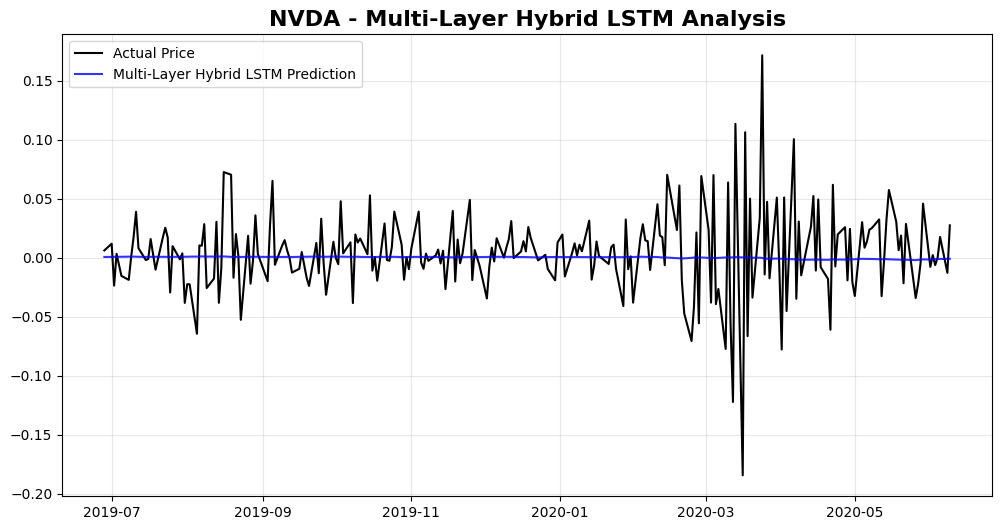

CPU times: user 437 ms, sys: 44.3 ms, total: 481 ms
Wall time: 608 ms


In [28]:
%%time
# --- Evaluation using the best hybrid/enhanced multi-layer model ---
print("\n--- Evaluating Best Multi-Layer Hybrid/Enhanced LSTM Model ---")

# Generate predictions on the hybrid/enhanced test set
multi_layer_preds_enh = multi_layer_model_enh.predict(X_test_enh, verbose=0)

# --- Correct way to inverse scale the predictions ---
# 1. Create a new scaler for the single target column ('Returns')
target_scaler_enh_ml = MinMaxScaler()  # Use a unique name

# 2. Fit it ONLY on the 'Returns' column of the TRAINING data
train_data_len_enh = len(enhanced_full_data) - len(y_test_enh)
target_scaler_enh_ml.fit(enhanced_full_data[["Returns"]][:train_data_len_enh])

# 3. Now, inverse transform using the correctly fitted scaler
y_test_enh_scaled = target_scaler_enh_ml.inverse_transform(y_test_enh.reshape(-1, 1))
multi_preds_scaled_enh = target_scaler_enh_ml.inverse_transform(multi_layer_preds_enh)

# Calculate and print metrics
multi_layer_metrics_enh = ut.calculate_metrics(
    y_test_enh_scaled, multi_preds_scaled_enh, "Multi-Layer Hybrid LSTM", y_train_enh
)
print(multi_layer_metrics_enh)

# Plot the results
test_dates_enh = enhanced_full_data.index[-len(y_test_enh_scaled) :]
ut.plot_non_keras_results(
    y_test_enh_scaled,
    multi_preds_scaled_enh,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Multi-Layer Hybrid LSTM",
)

### Baseline GRU Model

In [29]:
%%time
print("\n--- Tuning Baseline GRU Model ---")

# Define the input shape from your BASELINE training data
input_shape_base = (X_train_base.shape[1], X_train_base.shape[2])

# Instantiate the tuner for the GRU model
tuner_base_gru = kt.Hyperband(
    # Ensure the model builder uses the correct input shape
    hypermodel=lambda hp: mdl.build_gru(hp, input_shape=input_shape_base),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="baseline_gru",
    overwrite=False,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the BASELINE data
print("Starting GRU hyperparameter search on baseline data...")
tuner_base_gru.search(
    X_train_base,
    y_train_base,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_base_gru = tuner_base_gru.get_best_hyperparameters(num_trials=1)[0]
baseline_gru_model = tuner_base_gru.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Baseline GRU:
Units Layer 1: {best_hps_base_gru.get('units_1')}
Units Layer 2: {best_hps_base_gru.get('units_2')}
Dropout: {best_hps_base_gru.get('dropout'):.2f}
Learning Rate: {best_hps_base_gru.get('learning_rate')}
---
"""
)


--- Tuning Baseline GRU Model ---
Reloading Tuner from tuner_results/baseline_gru/tuner0.json
Starting GRU hyperparameter search on baseline data...

Hyperparameter search complete.

---
Optimal Hyperparameters for Baseline GRU:
Units Layer 1: 128
Units Layer 2: 32
Dropout: 0.10
Learning Rate: 0.01
---

CPU times: user 485 ms, sys: 45.5 ms, total: 531 ms
Wall time: 552 ms



--- Evaluating Best Baseline GRU Model ---
{'Model': 'Baseline GRU', 'RMSE': np.float64(0.03487160623964221), 'MAE': 0.024089815037837924, 'MAPE (%)': np.float64(12780.128635786681), 'R-squared': -0.012324827461973387, 'Directional_Accuracy': np.float64(62.4031007751938), 'MASE': np.float64(0.4562563959906157)}
Plot saved to Output/NVDA_Baseline_GRU_analysis.png


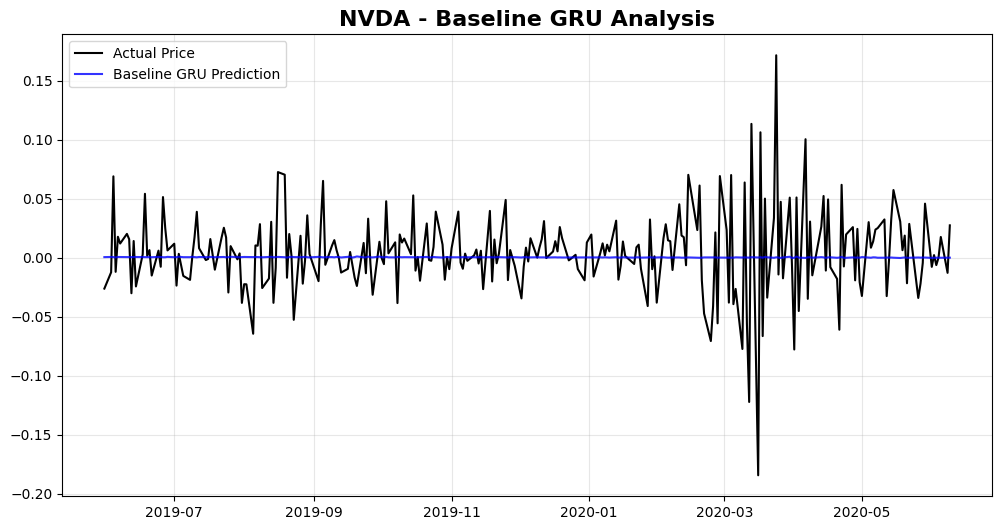

CPU times: user 413 ms, sys: 48.7 ms, total: 462 ms
Wall time: 880 ms


In [30]:
%%time
# --- Evaluation using the best baseline GRU model ---
print("\n--- Evaluating Best Baseline GRU Model ---")

# Generate predictions on the BASELINE test set
base_gru_preds = baseline_gru_model.predict(X_test_base, verbose=0)

# --- Correct way to inverse scale the predictions ---
# 1. Create a new scaler for the single target column ('Returns')
target_scaler_base_gru = MinMaxScaler()  # Use a unique name

# 2. Fit it ONLY on the 'Returns' column of the TRAINING data
train_data_len_base = len(tech_data) - len(y_test_base)
target_scaler_base_gru.fit(tech_data[["Returns"]][:train_data_len_base])

# 3. Now, inverse transform using the correctly fitted scaler
y_test_base_scaled = target_scaler_base_gru.inverse_transform(
    y_test_base.reshape(-1, 1)
)
base_gru_preds_scaled = target_scaler_base_gru.inverse_transform(base_gru_preds)


# Calculate and print metrics for the baseline GRU model
baseline_gru_metrics = ut.calculate_metrics(
    y_test_base_scaled, base_gru_preds_scaled, "Baseline GRU", y_train_base
)
print(baseline_gru_metrics)


# Plot the results
test_dates_base = tech_data.index[-len(y_test_base_scaled) :]
ut.plot_non_keras_results(
    y_test_base_scaled,
    base_gru_preds_scaled,
    test_dates_base,
    cfg.STOCK_SYMBOL,
    "Baseline GRU",
)

### Technical GRU Model

In [31]:
%%time
print("\n--- Tuning Technical GRU Model ---")

# Define the input shape from your TECHNICAL training data
input_shape_tech = (X_train_tech.shape[1], X_train_tech.shape[2])

# Instantiate the tuner for the technical GRU model
tuner_tech_gru = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_gru(hp, input_shape=input_shape_tech),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="technical_gru",
    overwrite=False,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the TECHNICAL data
print("Starting GRU hyperparameter search on technical data...")
tuner_tech_gru.search(
    X_train_tech,
    y_train_tech,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_tech_gru = tuner_tech_gru.get_best_hyperparameters(num_trials=1)[0]
technical_gru_model = tuner_tech_gru.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Technical GRU:
Units Layer 1: {best_hps_tech_gru.get('units_1')}
Units Layer 2: {best_hps_tech_gru.get('units_2')}
Dropout: {best_hps_tech_gru.get('dropout'):.2f}
Learning Rate: {best_hps_tech_gru.get('learning_rate')}
---
"""
)


--- Tuning Technical GRU Model ---
Reloading Tuner from tuner_results/technical_gru/tuner0.json
Starting GRU hyperparameter search on technical data...

Hyperparameter search complete.

---
Optimal Hyperparameters for Technical GRU:
Units Layer 1: 256
Units Layer 2: 32
Dropout: 0.30
Learning Rate: 0.01
---

CPU times: user 481 ms, sys: 49.2 ms, total: 530 ms
Wall time: 553 ms



--- Evaluating Best Technical GRU Model ---
{'Model': 'Technical GRU', 'RMSE': np.float64(0.0373423564209858), 'MAE': 0.02556944757475625, 'MAPE (%)': np.float64(24131.48656848787), 'R-squared': -0.12195941207781691, 'Directional_Accuracy': np.float64(53.36134453781513), 'MASE': np.float64(0.5001581703047037)}
Plot saved to Output/NVDA_Technical_GRU_analysis.png


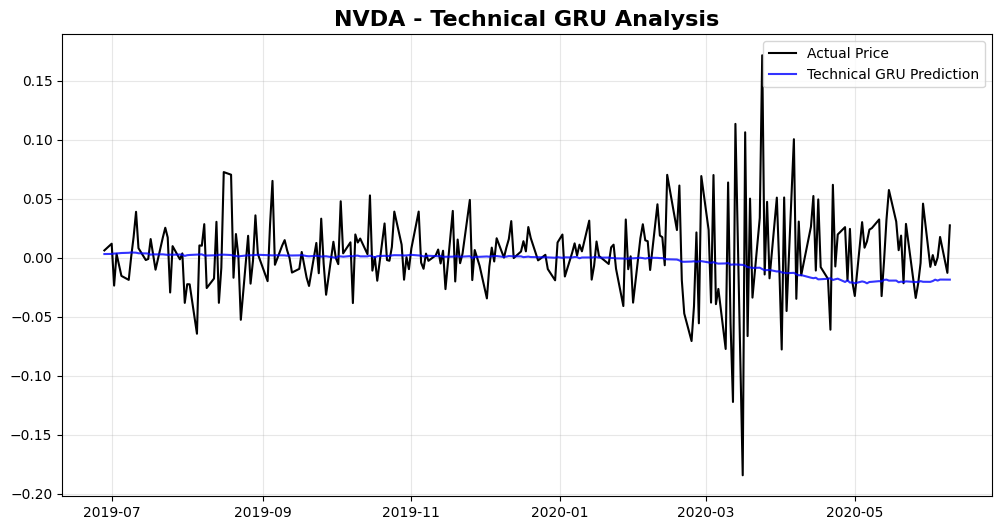

CPU times: user 421 ms, sys: 44.9 ms, total: 466 ms
Wall time: 710 ms


In [32]:
%%time
# --- Evaluation using the best technical GRU model ---
print("\n--- Evaluating Best Technical GRU Model ---")

# Generate predictions on the TECHNICAL test set
tech_gru_preds = technical_gru_model.predict(X_test_tech, verbose=0)

# --- Correct way to inverse scale the predictions ---
# 1. Create a new scaler for the single target column ('Returns')
target_scaler_tech_gru = MinMaxScaler()  # Use a unique name

# 2. Fit it ONLY on the 'Returns' column of the TRAINING data
train_data_len_tech = len(tech_data) - len(y_test_tech)
target_scaler_tech_gru.fit(tech_data[["Returns"]][:train_data_len_tech])

# 3. Now, inverse transform using the correctly fitted scaler
y_test_tech_scaled = target_scaler_tech_gru.inverse_transform(
    y_test_tech.reshape(-1, 1)
)
tech_gru_preds_scaled = target_scaler_tech_gru.inverse_transform(tech_gru_preds)

# Calculate and print metrics for the technical GRU model
technical_gru_metrics = ut.calculate_metrics(
    y_test_tech_scaled, tech_gru_preds_scaled, "Technical GRU", y_train_tech
)
print(technical_gru_metrics)

# Plot the results
test_dates_tech = tech_data.index[-len(y_test_tech_scaled) :]
ut.plot_non_keras_results(
    y_test_tech_scaled,
    tech_gru_preds_scaled,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "Technical GRU",
)

### Enhanced GRU Model

In [33]:
%%time
print("\n--- Tuning Hybrid/Enhanced GRU Model ---")

# Define the input shape from your HYBRID/ENHANCED training data
input_shape_enh = (X_train_enh.shape[1], X_train_enh.shape[2])

# Instantiate the tuner for the hybrid/enhanced GRU model
tuner_enh_gru = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_gru(hp, input_shape=input_shape_enh),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="enhanced_gru",
    overwrite=False,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the HYBRID/ENHANCED data
print("Starting GRU hyperparameter search on enhanced data...")
tuner_enh_gru.search(
    X_train_enh,
    y_train_enh,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_enh_gru = tuner_enh_gru.get_best_hyperparameters(num_trials=1)[0]
enhanced_gru_model = tuner_enh_gru.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Hybrid/Enhanced GRU:
Units Layer 1: {best_hps_enh_gru.get('units_1')}
Units Layer 2: {best_hps_enh_gru.get('units_2')}
Dropout: {best_hps_enh_gru.get('dropout'):.2f}
Learning Rate: {best_hps_enh_gru.get('learning_rate')}
---
"""
)


--- Tuning Hybrid/Enhanced GRU Model ---
Reloading Tuner from tuner_results/enhanced_gru/tuner0.json
Starting GRU hyperparameter search on enhanced data...

Hyperparameter search complete.

---
Optimal Hyperparameters for Hybrid/Enhanced GRU:
Units Layer 1: 256
Units Layer 2: 64
Dropout: 0.20
Learning Rate: 0.01
---

CPU times: user 484 ms, sys: 44.6 ms, total: 528 ms
Wall time: 545 ms



--- Evaluating Best Hybrid/Enhanced GRU Model ---
{'Model': 'Enhanced GRU', 'RMSE': np.float64(0.037602006836718896), 'MAE': 0.02608414822263681, 'MAPE (%)': np.float64(37723.778696139896), 'R-squared': -0.13761616517497366, 'Directional_Accuracy': np.float64(44.957983193277315), 'MASE': np.float64(0.5102261130534057)}
Plot saved to Output/NVDA_Enhanced_GRU_analysis.png


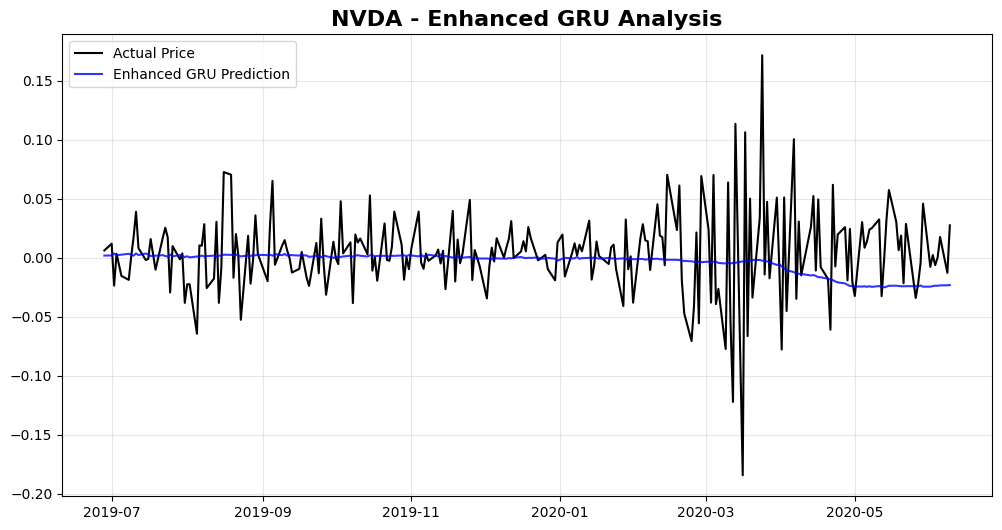

CPU times: user 383 ms, sys: 39.8 ms, total: 422 ms
Wall time: 439 ms


In [34]:
%%time
# --- Evaluation using the best hybrid/enhanced GRU model ---
print("\n--- Evaluating Best Hybrid/Enhanced GRU Model ---")

# Generate predictions on the HYBRID/ENHANCED test set
enh_gru_preds = enhanced_gru_model.predict(X_test_enh, verbose=0)

# --- Correct way to inverse scale the predictions ---
# 1. Create a new scaler for the single target column ('Returns')
target_scaler_enh_gru = MinMaxScaler()  # Use a unique name

# 2. Fit it ONLY on the 'Returns' column of the TRAINING data
train_data_len_enh = len(enhanced_full_data) - len(y_test_enh)
target_scaler_enh_gru.fit(enhanced_full_data[["Returns"]][:train_data_len_enh])

# 3. Now, inverse transform using the correctly fitted scaler
y_test_enh_scaled = target_scaler_enh_gru.inverse_transform(y_test_enh.reshape(-1, 1))
enh_gru_preds_scaled = target_scaler_enh_gru.inverse_transform(enh_gru_preds)

# Calculate and print metrics for the hybrid/enhanced GRU model
enhanced_gru_metrics = ut.calculate_metrics(
    y_test_enh_scaled, enh_gru_preds_scaled, "Enhanced GRU", y_train_enh
)
print(enhanced_gru_metrics)

# Plot the results
test_dates_enh = enhanced_full_data.index[-len(y_test_enh_scaled) :]
ut.plot_non_keras_results(
    y_test_enh_scaled,
    enh_gru_preds_scaled,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Enhanced GRU",
)

### Baseline SVM Model

In [35]:
%%time
# --- Preparing Data for Baseline SVM Model ---
print("\n--- Preparing Data for Baseline SVM Model ---")

# SVM requires 2D input, so we flatten the sequence data from the baseline dataset
nsamples, nx, ny = X_train_base.shape
X_train_svm_base = X_train_base.reshape((nsamples, nx * ny))

nsamples, nx, ny = X_test_base.shape
X_test_svm_base = X_test_base.reshape((nsamples, nx * ny))

# We'll use the original y_train and y_test, but we need to flatten y_train for the model's fit method
y_train_svm_base = y_train_base.ravel()
y_test_svm_base = y_test_base.ravel()

print(
    f"Reshaped Baseline data for SVM: X_train={X_train_svm_base.shape}, y_train={y_train_svm_base.shape}"
)


--- Preparing Data for Baseline SVM Model ---
Reshaped Baseline data for SVM: X_train=(2296, 60), y_train=(2296,)
CPU times: user 181 µs, sys: 73 µs, total: 254 µs
Wall time: 182 µs



--- Tuning and Training Baseline SVM Model ---
Building and tuning SVM model with GridSearchCV...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find accepta

[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END ...........C=1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........C=1, epsil

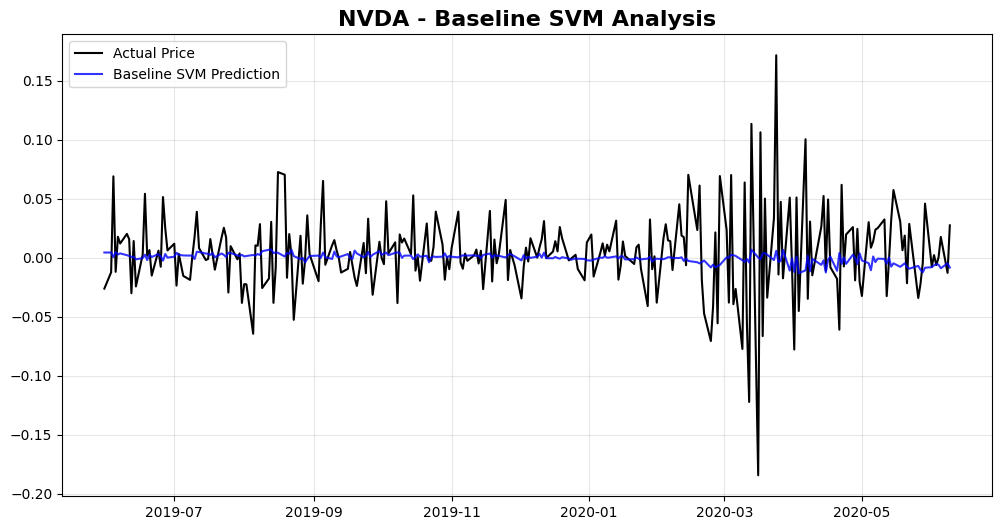

CPU times: user 274 ms, sys: 225 ms, total: 498 ms
Wall time: 6.86 s


In [36]:
%%time
# --- Build and train the SVM using the baseline data ---
print("\n--- Tuning and Training Baseline SVM Model ---")
baseline_svm_model = mdl.build_and_train_svm(X_train_svm_base, y_train_svm_base)

# --- Evaluate the best model found ---
print("\n--- Evaluating Best Baseline SVM Model ---")
base_svm_preds = baseline_svm_model.predict(X_test_svm_base)

# --- Correct way to inverse scale the predictions ---
# 1. Create a new scaler for the single target column ('Returns')
target_scaler_svm_base = MinMaxScaler()  # Use a unique name

# 2. Fit it ONLY on the 'Returns' column of the TRAINING data
train_data_len_base = len(tech_data) - len(y_test_base)
target_scaler_svm_base.fit(tech_data[["Returns"]][:train_data_len_base])

# 3. Now, inverse transform using the correctly fitted scaler
y_test_svm_base_scaled = target_scaler_svm_base.inverse_transform(
    y_test_base.reshape(-1, 1)
)
base_svm_preds_scaled = target_scaler_svm_base.inverse_transform(
    base_svm_preds.reshape(-1, 1)
)


# Calculate and print metrics
baseline_svm_metrics = ut.calculate_metrics(
    y_test_svm_base_scaled, base_svm_preds_scaled, "Baseline SVM", y_train_base
)
print(baseline_svm_metrics)


# Plot the results
test_dates_base = tech_data.index[-len(y_test_svm_base_scaled) :]
ut.plot_non_keras_results(
    y_test_svm_base_scaled,
    base_svm_preds_scaled,
    test_dates_base,
    cfg.STOCK_SYMBOL,
    "Baseline SVM",
)

#### Technical SVM Model

In [37]:
%%time
# --- Preparing Data for Technical SVM Model ---
print("\n--- Preparing Data for Technical SVM Model ---")

# SVM requires 2D input, so we flatten the sequence data from the technical dataset
nsamples, nx, ny = X_train_tech.shape
X_train_svm_tech = X_train_tech.reshape((nsamples, nx * ny))

nsamples, nx, ny = X_test_tech.shape
X_test_svm_tech = X_test_tech.reshape((nsamples, nx * ny))

# Flatten the y_train and y_test arrays for the SVM's fit method
y_train_svm_tech = y_train_tech.ravel()
y_test_svm_tech = y_test_tech.ravel()

print(
    f"Reshaped Technical data for SVM: X_train={X_train_svm_tech.shape}, y_train={y_train_svm_tech.shape}"
)


--- Preparing Data for Technical SVM Model ---
Reshaped Technical data for SVM: X_train=(2118, 540), y_train=(2118,)
CPU times: user 148 µs, sys: 113 µs, total: 261 µs
Wall time: 207 µs



--- Tuning and Training Technical SVM Model ---
Building and tuning SVM model with GridSearchCV...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END ..........C=1, epsil

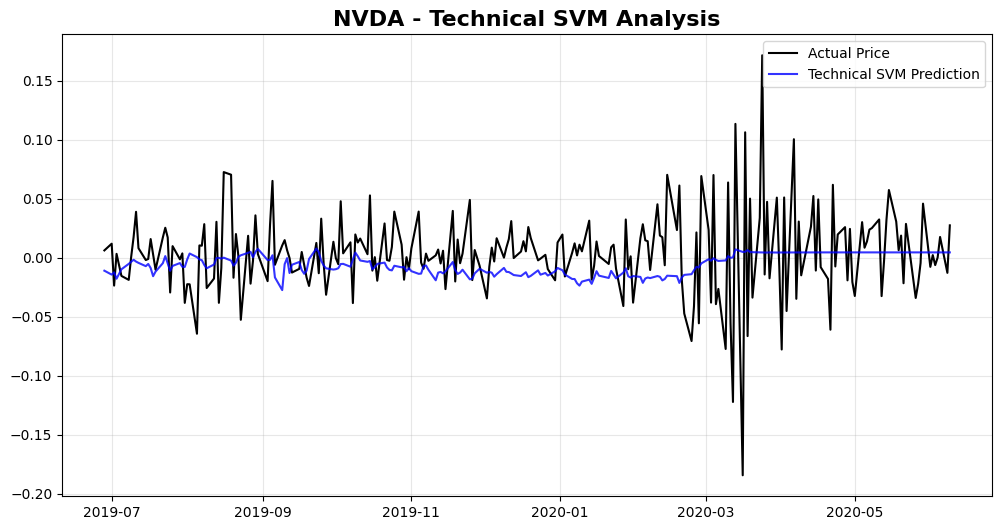

CPU times: user 236 ms, sys: 33.2 ms, total: 269 ms
Wall time: 2 s


In [38]:
%%time
# --- Build and train the SVM using the technical data ---
print("\n--- Tuning and Training Technical SVM Model ---")
technical_svm_model = mdl.build_and_train_svm(X_train_svm_tech, y_train_svm_tech)

# --- Evaluate the best model found ---
print("\n--- Evaluating Best Technical SVM Model ---")
tech_svm_preds = technical_svm_model.predict(X_test_svm_tech)

# --- Correct way to inverse scale the predictions ---
# 1. Create a new scaler for the single target column ('Returns')
target_scaler_svm_tech = MinMaxScaler()  # Use a unique name

# 2. Fit it ONLY on the 'Returns' column of the TRAINING data
train_data_len_tech = len(tech_data) - len(y_test_tech)
target_scaler_svm_tech.fit(tech_data[["Returns"]][:train_data_len_tech])

# 3. Now, inverse transform using the correctly fitted scaler
y_test_svm_tech_scaled = target_scaler_svm_tech.inverse_transform(
    y_test_tech.reshape(-1, 1)
)
tech_svm_preds_scaled = target_scaler_svm_tech.inverse_transform(
    tech_svm_preds.reshape(-1, 1)
)


# Calculate and print metrics
technical_svm_metrics = ut.calculate_metrics(
    y_test_svm_tech_scaled, tech_svm_preds_scaled, "Technical SVM", y_train_tech
)
print(technical_svm_metrics)


# Plot the results
test_dates_tech = tech_data.index[-len(y_test_svm_tech_scaled) :]
ut.plot_non_keras_results(
    y_test_svm_tech_scaled,
    tech_svm_preds_scaled,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "Technical SVM",
)

### Enhanced SVM Model

In [39]:
%%time
# --- Preparing Data for Hybrid/Enhanced SVM Model ---
print("\n--- Preparing Data for Hybrid/Enhanced SVM Model ---")

# SVM requires 2D input, so we flatten the sequence data from the enhanced dataset
nsamples, nx, ny = X_train_enh.shape
X_train_svm_enh = X_train_enh.reshape((nsamples, nx * ny))

nsamples, nx, ny = X_test_enh.shape
X_test_svm_enh = X_test_enh.reshape((nsamples, nx * ny))

# Flatten the y_train and y_test arrays for the SVM's fit method
y_train_svm_enh = y_train_enh.ravel()
y_test_svm_enh = y_test_enh.ravel()

print(
    f"Reshaped Enhanced data for SVM: X_train={X_train_svm_enh.shape}, y_train={y_train_svm_enh.shape}"
)


--- Preparing Data for Hybrid/Enhanced SVM Model ---
Reshaped Enhanced data for SVM: X_train=(2118, 660), y_train=(2118,)
CPU times: user 216 µs, sys: 45 µs, total: 261 µs
Wall time: 229 µs



--- Tuning and Training Hybrid/Enhanced SVM Model ---
Building and tuning SVM model with GridSearchCV...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.4s
[CV] END ...........C=1

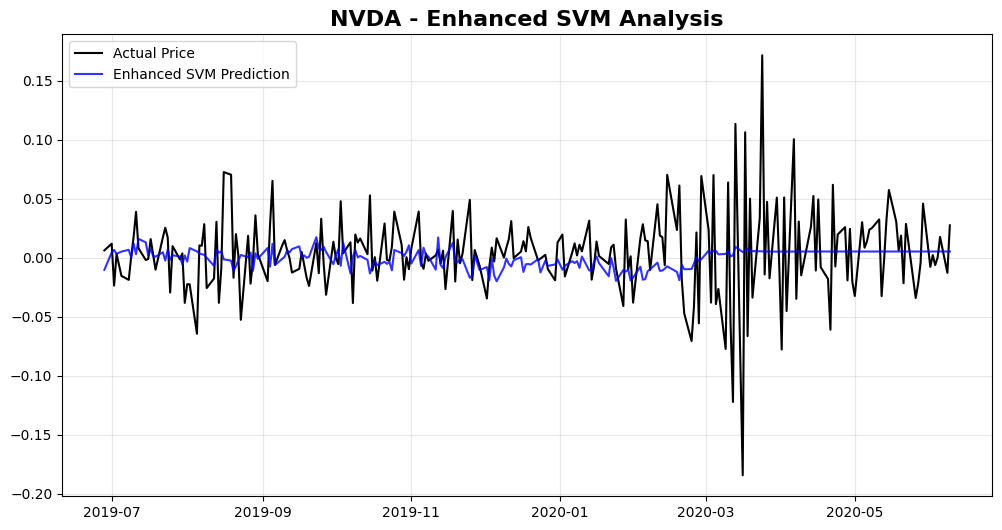

CPU times: user 407 ms, sys: 60.7 ms, total: 468 ms
Wall time: 2.7 s


In [40]:
%%time
# --- Build and train the SVM using the hybrid/enhanced data ---
print("\n--- Tuning and Training Hybrid/Enhanced SVM Model ---")
enhanced_svm_model = mdl.build_and_train_svm(X_train_svm_enh, y_train_svm_enh)

# --- Evaluate the best model found ---
print("\n--- Evaluating Best Hybrid/Enhanced SVM Model ---")
enh_svm_preds = enhanced_svm_model.predict(X_test_svm_enh)

# --- Correct way to inverse scale the predictions ---
# 1. Create a new scaler for the single target column ('Returns')
target_scaler_svm_enh = MinMaxScaler()  # Use a unique name

# 2. Fit it ONLY on the 'Returns' column of the TRAINING data
train_data_len_enh = len(enhanced_full_data) - len(y_test_enh)
target_scaler_svm_enh.fit(enhanced_full_data[["Returns"]][:train_data_len_enh])

# 3. Now, inverse transform using the correctly fitted scaler
y_test_svm_enh_scaled = target_scaler_svm_enh.inverse_transform(
    y_test_enh.reshape(-1, 1)
)
enh_svm_preds_scaled = target_scaler_svm_enh.inverse_transform(
    enh_svm_preds.reshape(-1, 1)
)


# Calculate and print metrics
enhanced_svm_metrics = ut.calculate_metrics(
    y_test_svm_enh_scaled, enh_svm_preds_scaled, "Enhanced SVM", y_train_enh
)
print(enhanced_svm_metrics)


# Plot the results
test_dates_enh = enhanced_full_data.index[-len(y_test_svm_enh_scaled) :]
ut.plot_non_keras_results(
    y_test_svm_enh_scaled,
    enh_svm_preds_scaled,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Enhanced SVM",
)

### ARIMA Model


--- Preparing Data and Finding Best ARIMA Order ---
ARIMA Training Data Size: 2148
ARIMA Test Data Size: 239
Searching for the best ARIMA order...
Best ARIMA order found: (0, 0, 0) with AIC: -9667.65

Plotting ACF and PACF of the differenced series...


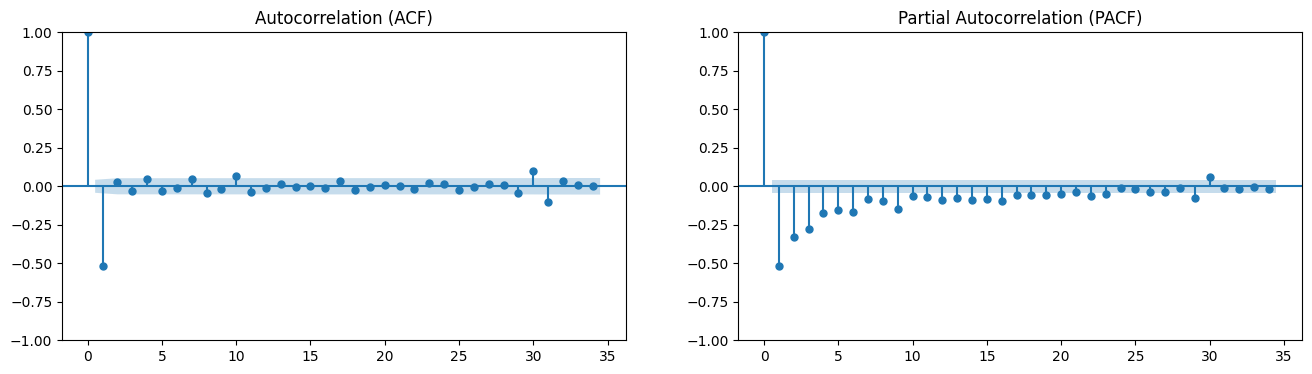

CPU times: user 10.1 s, sys: 182 ms, total: 10.3 s
Wall time: 10.6 s


In [41]:
%%time
print("\n--- Preparing Data and Finding Best ARIMA Order ---")

# ARIMA works on a single (univariate) time series. We'll use the target variable directly.
# Using 'enhanced_full_data' ensures we have the longest consistent timeseries available.
target_series = enhanced_full_data[cfg.HYBRID_TARGET].dropna()

# Split the data for training and testing
train_size = int(len(target_series) * (1 - cfg.TEST_SIZE))
train_arima, test_arima = target_series[0:train_size], target_series[train_size:]

print(f"ARIMA Training Data Size: {len(train_arima)}")
print(f"ARIMA Test Data Size: {len(test_arima)}")


# Find the best (p,d,q) order using the auto-ARIMA function
# This might take a few minutes depending on the data size.
best_arima_order = mdl.find_best_arima_order(train_arima)


# Plot ACF and PACF for visual inspection to help verify the p and q values.
print("\nPlotting ACF and PACF of the differenced series...")
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(train_arima.diff().dropna(), ax=axes[0], title="Autocorrelation (ACF)")
plot_pacf(
    train_arima.diff().dropna(),
    ax=axes[1],
    title="Partial Autocorrelation (PACF)",
    method="ywm",
)
plt.show()

In [42]:
%%time
print(f"\n--- Running ARIMA Model with best order {best_arima_order} ---")

# Initialize a list with the training data, which will be updated at each step
history = [x for x in train_arima]
arima_predictions = []

print(f"Performing rolling forecast for {len(test_arima)} steps...")

# Use tqdm for a progress bar, which is helpful for long-running loops
for t in tqdm(range(len(test_arima)), desc="ARIMA Rolling Forecast"):
    # Build and train the ARIMA model on the current history
    # The model is retrained at each step to incorporate the latest data
    model_arima = mdl.build_and_train_arima(history, order=best_arima_order)

    # Forecast one step ahead
    output = model_arima.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)

    # Append the actual observed value to history for the next iteration
    obs = test_arima.iloc[t]
    history.append(obs)

print("ARIMA forecast complete.")


--- Running ARIMA Model with best order (0, 0, 0) ---
Performing rolling forecast for 239 steps...


ARIMA Rolling Forecast:  14%|█▍        | 33/239 [00:03<00:20, 10.11it/s]/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
ARIMA Rolling Forecast: 100%|██████████| 239/239 [00:30<00:00,  7.86it/s]

ARIMA forecast complete.
CPU times: user 28.7 s, sys: 497 ms, total: 29.2 s
Wall time: 30.4 s



--- Evaluating ARIMA Model ---
{'Model': 'ARIMA', 'RMSE': np.float64(0.035341371243603883), 'MAE': 0.024276968319382152, 'MAPE (%)': np.float64(64322.68108969139), 'R-squared': -0.0049408464051756695, 'Directional_Accuracy': np.float64(24.789915966386555), 'MASE': np.float64(0.9679298209617198)}
Plot saved to Output/NVDA_ARIMA0,_0,_0_analysis.png


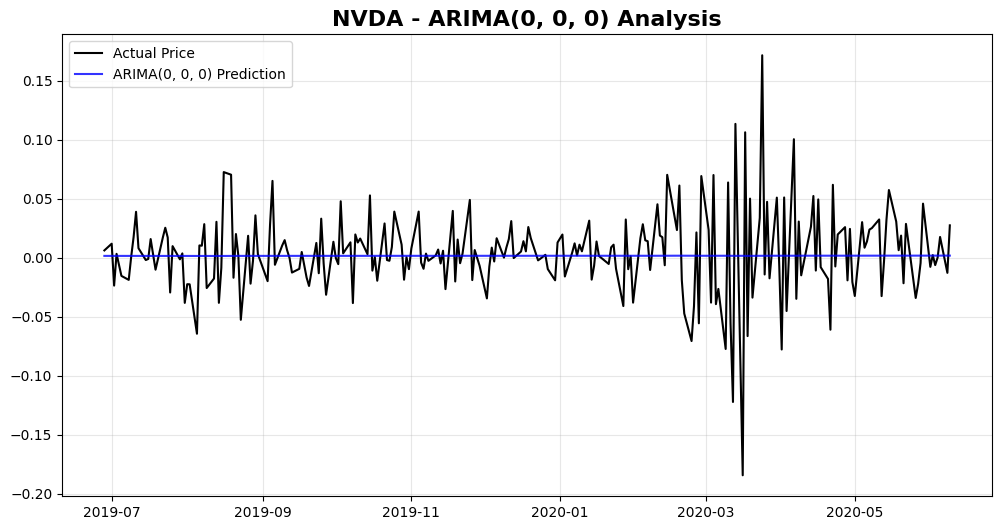

CPU times: user 118 ms, sys: 11 ms, total: 129 ms
Wall time: 132 ms


In [43]:
%%time
# --- Evaluate the ARIMA Model ---
print("\n--- Evaluating ARIMA Model ---")

# Convert predictions to a NumPy array for calculations
arima_predictions_np = np.array(arima_predictions)

# The data is already in its original scale, so no inverse transform is needed.
arima_metrics = ut.calculate_metrics(
    test_arima.values, arima_predictions_np, "ARIMA", train_arima.values
)
print(arima_metrics)

# --- Plot the Results ---
# Get the dates corresponding to the test set for the x-axis
test_dates_arima = target_series.index[train_size:]

ut.plot_non_keras_results(
    test_arima.values,
    arima_predictions_np,
    test_dates_arima,
    cfg.STOCK_SYMBOL,
    f"ARIMA{best_arima_order}",
)

### 7. Final Performance Comparison

In [44]:
%%time

# --- 1. Create a Naive Baseline for Comparison ---
# A naive forecast simply uses the previous day's value as the prediction for the current day.
# We use the scaled baseline data for a fair comparison.
print("--- Calculating Naive Baseline ---")
naive_preds = np.roll(y_test_base_scaled, 1)
# The first element has no prior value, so we'll just use its own value, resulting in zero error for that step.
naive_preds[0] = y_test_base_scaled[0]
naive_metrics = ut.calculate_metrics(
    y_test_base_scaled, naive_preds, "Naive Baseline", y_train_base
)


# --- 2. Consolidate All Model Metrics ---
# Gather all the metric dictionaries we created into a single list.
all_metrics_list = [
    naive_metrics,
    # Single-Layer LSTMs
    baseline_lstm_metrics,
    tech_metrics,  # Renamed from baseline_metrics for clarity
    enh_metrics,
    # Multi-Layer LSTMs
    multi_layer_metrics_base,
    multi_layer_metrics_tech,
    multi_layer_metrics_enh,
    # GRUs
    baseline_gru_metrics,
    technical_gru_metrics,
    enhanced_gru_metrics,
    # SVMs
    baseline_svm_metrics,
    technical_svm_metrics,
    enhanced_svm_metrics,
    # ARIMA
    arima_metrics,
]

# Create a DataFrame for easy viewing and analysis
all_metrics_df = pd.DataFrame(all_metrics_list).round(4)


# --- 3. Print the Comprehensive Performance Table ---
print("\n📊 COMPREHENSIVE PERFORMANCE COMPARISON")
print("-" * 75)
# Use to_string() to ensure all columns are displayed without truncation
print(all_metrics_df.to_string())
print("-" * 75)


# --- 4. Determine and Announce the Best Model for Each Metric ---
metrics_to_evaluate = {
    "RMSE": "min",
    "MAE": "min",
    "MAPE (%)": "min",
    "MASE": "min",
    "R-squared": "max",
    "Directional_Accuracy": "max",
}

print("\n🏆 Best Model for Each Metric")
print("-" * 75)
for metric, method in metrics_to_evaluate.items():
    if method == "min":
        # For metrics where lower is better (e.g., RMSE, MAE)
        winner_idx = all_metrics_df[metric].idxmin()
    else:
        # For metrics where higher is better (e.g., R-squared)
        winner_idx = all_metrics_df[metric].idxmax()

    winner_row = all_metrics_df.loc[winner_idx]
    print(f"{metric:<22}: {winner_row['Model']} (Score: {winner_row[metric]:.4f})")
print("-" * 75)

--- Calculating Naive Baseline ---

📊 COMPREHENSIVE PERFORMANCE COMPARISON
---------------------------------------------------------------------------
                          Model    RMSE     MAE     MAPE (%)  R-squared  Directional_Accuracy    MASE
0                Naive Baseline  0.0557  0.0377  634788.0030    -1.5845               29.0698  0.7131
1                 Baseline LSTM  0.0347  0.0240    9837.8202    -0.0017               62.4031  0.4540
2   Single-Layer Technical LSTM  0.0355  0.0244   12375.4779    -0.0134               28.5714  0.4777
3      Single-Layer Hybrid LSTM  0.0409  0.0283   18726.6562    -0.3457               70.5882  0.5545
4     Multi-Layer Baseline LSTM  0.0350  0.0242    1613.2117    -0.0213               31.3953  0.4586
5    Multi-Layer Technical LSTM  0.0354  0.0244   12369.7728    -0.0109               74.7899  0.4767
6       Multi-Layer Hybrid LSTM  0.0355  0.0243   30144.9691    -0.0136               71.4286  0.4762
7                  Baseline GRU  

In [45]:
%%time

# --- 5. Rank Models Based on Overall Performance ---
print("\n--- Ranking All Models ---")
ranking_df = all_metrics_df.copy()

# Define which metrics to rank. True means "lower is better" (ascending).
ranking_criteria = {
    "RMSE": True,
    "MAE": True,
    "MAPE (%)": True,
    "MASE": True,
    "R-squared": False,  # False means "higher is better" (descending)
    "Directional_Accuracy": False,
}

# Generate rank columns dynamically based on the criteria
for metric, ascending_order in ranking_criteria.items():
    ranking_df[f"{metric}_Rank"] = ranking_df[metric].rank(
        method="min", ascending=ascending_order
    )


# --- Create a Final Score ---
# Define which ranks contribute to the total score. You can easily change this.
# For example, you might decide RMSE is more important than MAE.
rank_components = ["MASE_Rank", "MAPE (%)_Rank", "Directional_Accuracy_Rank"]
ranking_df["Total_Rank"] = ranking_df[rank_components].sum(axis=1)

# Sort by the final rank to find the best overall model
final_ranking = ranking_df.sort_values(by="Total_Rank", ascending=True)

# Define the columns you want to see in the final table
display_cols = [
    "Model",
    "Total_Rank",
    "RMSE",
    "MAPE (%)",
    "MASE",
    "R-squared",
    "Directional_Accuracy",
]

# --- Display Final Ranking Table ---
print("\n🏆🏆🏆 OVERALL MODEL RANKING (Lower Total_Rank is Better) 🏆🏆🏆")
print("-" * 115)
print(final_ranking[display_cols].reset_index(drop=True).to_string())
print("-" * 115)

# --- Announce the Winner ---
winner = final_ranking.iloc[0]
print(
    f"\n🎉 The overall best performing model is: '{winner['Model']}' with a Total Rank score of {winner['Total_Rank']:.0f}."
)


--- Ranking All Models ---

🏆🏆🏆 OVERALL MODEL RANKING (Lower Total_Rank is Better) 🏆🏆🏆
-------------------------------------------------------------------------------------------------------------------
                          Model  Total_Rank    RMSE     MAPE (%)    MASE  R-squared  Directional_Accuracy
0                 Baseline LSTM         7.0  0.0347    9837.8202  0.4540    -0.0017               62.4031
1    Multi-Layer Technical LSTM        10.0  0.0354   12369.7728  0.4767    -0.0109               74.7899
2                  Baseline GRU        11.0  0.0349   12780.1286  0.4563    -0.0123               62.4031
3     Multi-Layer Baseline LSTM        15.0  0.0350    1613.2117  0.4586    -0.0213               31.3953
4       Multi-Layer Hybrid LSTM        15.0  0.0355   30144.9691  0.4762    -0.0136               71.4286
5      Single-Layer Hybrid LSTM        21.0  0.0409   18726.6562  0.5545    -0.3457               70.5882
6                  Baseline SVM        21.0  0.0351   

Plot saved to Output/NVDA_all_models_comparison.png


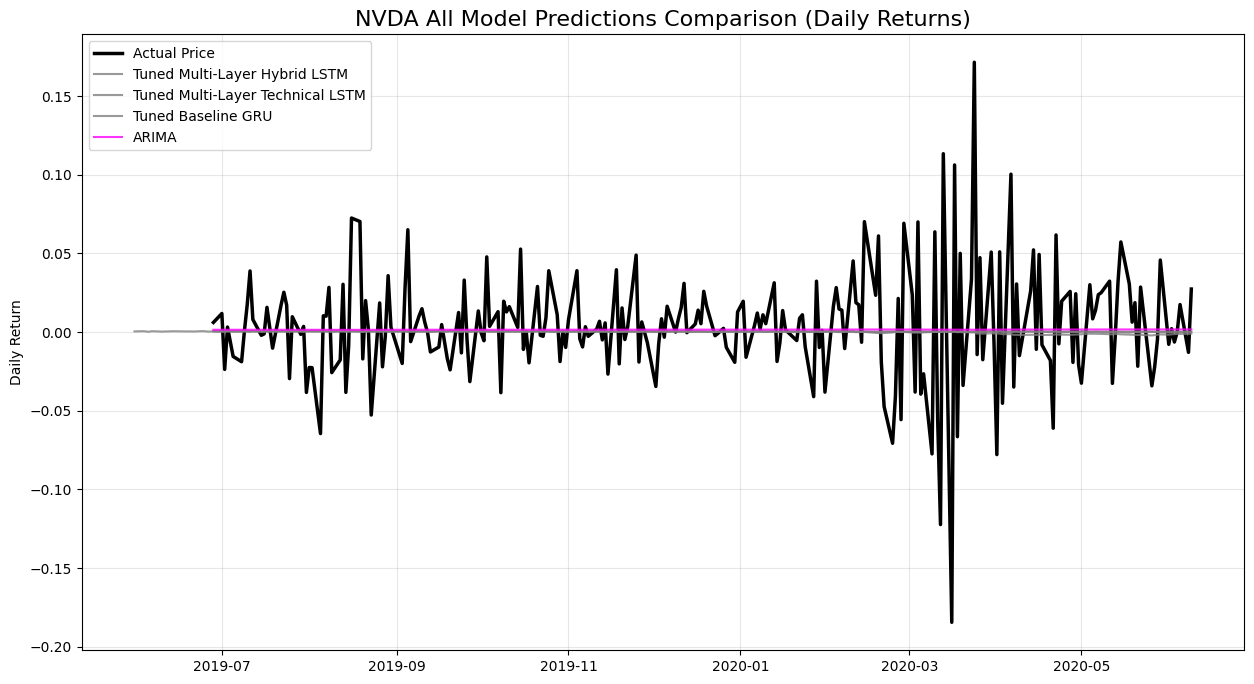

CPU times: user 153 ms, sys: 8.59 ms, total: 162 ms
Wall time: 165 ms


In [46]:
%%time

# --- 6. Plot Final Comparison of All Major Models ---

# Create a dictionary containing the data for the final plot.
# Each entry needs the date series and the corresponding predicted values.
plot_data = {
    # The 'Actual' values from the longest available dataset (enhanced)
    "Actual": {"dates": test_dates_enh, "values": y_test_enh_scaled},
    # --- Best Models from Each Category for Clarity ---
    # You can uncomment more models, but the plot may become cluttered.
    # We'll start by plotting the best-ranked models.
    # Best Overall Model (Example: replace with your actual winner)
    "Tuned Multi-Layer Hybrid LSTM": {
        "dates": test_dates_enh,
        "values": multi_preds_scaled_enh,
    },
    # Best Technical Model (Example)
    "Tuned Multi-Layer Technical LSTM": {
        "dates": test_dates_tech,
        "values": multi_preds_scaled_tech,
    },
    # Best Baseline Model (Example)
    "Tuned Baseline GRU": {"dates": test_dates_base, "values": base_gru_preds_scaled},
    # Classical Benchmark
    "ARIMA": {"dates": test_dates_arima, "values": arima_predictions_np},
}

# --- Optional: Uncomment the block below to plot ALL models ---
# plot_data = {
#     "Actual": {"dates": test_dates_enh, "values": y_test_enh_scaled},
#     "Baseline LSTM": {"dates": test_dates_base, "values": base_preds_scaled},
#     "Technical LSTM": {"dates": test_dates_tech, "values": tech_preds_scaled},
#     "Hybrid LSTM": {"dates": test_dates_enh, "values": enh_preds_scaled},
#     "Baseline Multi-Layer LSTM": {"dates": test_dates_base, "values": multi_preds_scaled_base},
#     "Technical Multi-Layer LSTM": {"dates": test_dates_tech, "values": multi_preds_scaled_tech},
#     "Hybrid Multi-Layer LSTM": {"dates": test_dates_enh, "values": multi_preds_scaled_enh},
#     "Baseline GRU": {"dates": test_dates_base, "values": base_gru_preds_scaled},
#     "Technical GRU": {"dates": test_dates_tech, "values": tech_gru_preds_scaled},
#     "Hybrid GRU": {"dates": test_dates_enh, "values": enh_gru_preds_scaled},
#     "Baseline SVM": {"dates": test_dates_base, "values": base_svm_preds_scaled},
#     "Technical SVM": {"dates": test_dates_tech, "values": tech_svm_preds_scaled},
#     "Hybrid SVM": {"dates": test_dates_enh, "values": enh_svm_preds_scaled},
#     "ARIMA": {"dates": test_dates_arima, "values": arima_predictions_np},
# }

# Call the plotting function from your utils file
ut.plot_final_comparison(
    plot_data,
    cfg.STOCK_SYMBOL,
    f"{cfg.STOCK_SYMBOL} All Model Predictions Comparison (Daily Returns)",
)

In [47]:
try:
    end_time = time.time()
    total_time = end_time - start_time
    print(f"--- Total Notebook Runtime: {ut.format_runtime(total_time)} seconds ---")
except NameError:
    print("⚠️ --- Timer could not be stopped because 'start_time' was not defined.")

--- Total Notebook Runtime: 1 minute 9.70 seconds seconds ---
